# General Setup

In [1]:
# standard imports
import torch
import numpy as np
import sys
import matplotlib.pyplot as plt
from functools import reduce

# imports from representation-itl library
import repitl.kernel_utils as ku
import repitl.matrix_itl as itl
import repitl.divergences as div

# Experimental Setup

Configuration for experiments

In [2]:
alphaList = [1.01, 2.0, 5.0]    # list of different alphas for the jensen-reyni divergence

numSamples = 100                 # number of data samples
numDimensions = 10              # number of dimensions to try
numDiffs = 10                    # number of differences to try
numRepetitions = 10             # number of times to repeat the experiment
permTestSize = 50               # size of permutation test
significance = 0.05             # significance level

# The following configs match what was done in the paper. 
# However, they were used on a cluster and are therefore not practical for sequential code
# numSamples = 250                 # number of data samples
# numDimensions = 10              # number of dimensions to try
# numDiffs = 20                    # number of differences to try
# numRepetitions = 100             # number of times to repeat the experiment
# permTestSize = 500               # size of permutation test
# significance = 0.05             # significance level


dimLowerBound, dimUpperBound = 2, 2500.01
dimensionList = np.logspace(np.log10(dimLowerBound), np.log10(dimUpperBound), numDimensions, dtype=int)

Functions that are used in both mean and variance test

In [3]:
def mmd(x, y, sigma):
    # compare kernel MMD paper and code:
    # A. Gretton et al.: A kernel two-sample test, JMLR 13 (2012)
    # http://www.gatsby.ucl.ac.uk/~gretton/mmd/mmd.htm
    # x shape [n, d] y shape [m, d]
    # n_perm number of bootstrap permutations to get p-value, pass none to not get p-value
    n, d = x.shape
    m, d2 = y.shape
    assert d == d2
    xy = torch.cat([x.detach(), y.detach()], dim=0)
    dists = torch.cdist(xy, xy, p=2.0)
    # we are a bit sloppy here as we just keep the diagonal and everything twice
    # note that sigma should be squared in the RBF to match the Gretton et al heuristic
    k = torch.exp((-1 / (2 * sigma ** 2)) * dists ** 2)
    k_x = k[:n, :n]
    k_y = k[n:, n:]
    k_xy = k[:n, n:]
    # The diagonals are always 1 (up to numerical error, this is (3) in Gretton et al.)
    # note that their code uses the biased (and differently scaled mmd)
    # mmd unbiased does not sum the diagonal terms.
    mmd = (k_x.sum() - n) / (n * (n - 1)) + (k_y.sum() - m) / (m * (m - 1)) - 2 * k_xy.sum() / (n * m)
    return mmd


def mmd_permutation_test(x, y, sigma, significance, rep):
    """
    Performs a permutation test on the MMD method
    """
    
    N_X = len(x)
    N_Y = len(y)
    xy = torch.cat([x, y], dim=0).double()
    mmds = []
    
    for i in range(rep):
        xy = xy[torch.randperm(len(xy))]
        mmds.append(mmd(xy[:N_X, :], xy[N_X:, :], sigma).item())
        
    mmds = torch.tensor(mmds)
    thr_mmd = torch.quantile(mmds, (1 - significance))
    return thr_mmd

def jrd_permutation_test(x, y, sigma, alpha, significance, rep):
    """
    Performs a permutation test on the JRD method with a given alpha
    """
    
    N_X = len(x)
    N_Y = len(y)
    xy = torch.cat([x, y], dim=0).double()
    jrd = []
    
    for i in range(rep):
        xy = xy[torch.randperm(len(xy))]
        jrd.append(div.divergenceJR(xy[:N_X, :], xy[N_X:, :], sigma, alpha).item())
        
    jrd = torch.tensor(jrd)
    thr_jrd = torch.quantile(jrd, (1 - significance))
    return thr_jrd

def run_experiment(iterableDiffs, dataGenFunction):
    """
    Generalized form of the mean/variance experiment
    
    Inputs:
        dataGenFunction: A function that creates gaussian data with a specific mean or variance.
                         This data generation function is specific to the actual experiment, such as means differences experiment.
                         
        iterableDiffs: A list of differnet values to iterate over. Can be differences in means or variances.
                       Items inside are passed to the dataGenFunction to create data
    """
    
    # storage for results
    mmd_intermediateResults = np.zeros([numRepetitions, numDimensions, len(iterableDiffs)])
    jrd_intermediateResults = np.zeros([len(alphaList), numRepetitions, numDimensions, len(iterableDiffs)])

    # main experiment loop
    for repIdx in range(numRepetitions):
        for dIdx, dim in enumerate(dimensionList):
            for itIdx, diff in enumerate(iterableDiffs):
                # construct two distributions
                X, Y = dataGenFunction(dim, diff)
                
                # create mixture
                XY = torch.from_numpy(np.concatenate([X, Y]))

                # calculate euclidean distances and kernel bandwidth
                dists = ku.squaredEuclideanDistance(XY, XY)
                sigma = torch.sqrt(torch.sum(dists) / ( ((numSamples*2)**2 - (numSamples*2)) * 2 ))

                # collect MMD baeline and permutation test
                mmd_ = mmd(X, Y, sigma)
                thr_mmd = mmd_permutation_test(X, Y, sigma, significance, permTestSize)
                if thr_mmd < mmd_:
                    mmd_intermediateResults[repIdx, dIdx, itIdx] = 1

                # collect JRD baeline and permutation test for different alphas
                for alphaIdx, alpha in enumerate(alphaList):
                    jrd_ = div.divergenceJR(X, Y, sigma, alpha)
                    thr_jrd = jrd_permutation_test(X, Y, sigma, alpha, significance, permTestSize)
                    if thr_jrd < jrd_:
                        jrd_intermediateResults[alphaIdx, repIdx, dIdx, itIdx] = 1
                        
    return mmd_intermediateResults, jrd_intermediateResults

# Mean Test

Gaussian means test from Gretton 2012 paper. The two distributions have the same variance, but increasingly differing means.

In [4]:
# create two distributions with unit variance, and with given dimension and difference in means
def generate_mean_test_distributions(dim, meanDiff):
    identity = np.eye(dim)
        
    xMean = np.zeros(dim)
    yMean = np.full(dim, meanDiff / (dim**0.5))
    X = torch.from_numpy(np.random.multivariate_normal(mean=xMean, cov=identity, size=numSamples))
    Y = torch.from_numpy(np.random.multivariate_normal(mean=yMean, cov=identity, size=numSamples))
    
    return X, Y


meanDiffs = np.logspace(np.log10(0.05), np.log10(50), numDiffs)
meanResults_mmd, meanResults_jrd = run_experiment(meanDiffs, generate_mean_test_distributions)

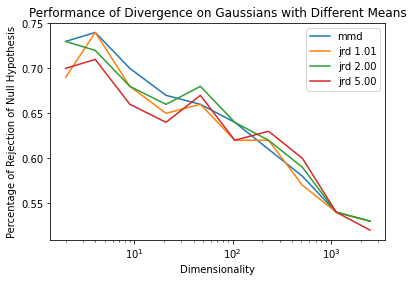

In [5]:
# compute averages
compactResults_mmd = np.mean(meanResults_mmd[:,:,:], axis=0)
averaged_mmd = np.mean(compactResults_mmd, axis=1)
plt.plot(dimensionList, averaged_mmd, label='mmd')

for alphaIdx, alpha in enumerate(alphaList):
    compactResults_jrd = np.mean(meanResults_jrd[alphaIdx,:,:,:], axis=0)
    averaged_jrd = np.mean(compactResults_jrd, axis=1)
    plt.plot(dimensionList, averaged_jrd, label='jrd %.2f' % alpha)

plt.title("Performance of Divergence on Gaussians with Different Means")
plt.legend()
plt.xlabel("Dimensionality")
plt.ylabel("Percentage of Rejection of Null Hypothesis")
plt.xscale('log')
plt.show()

# Variance Test

Gaussian variance test from Gretton 2012 paper. The two distributions have the same mean, but increasingly differing variances.

In [6]:
# create two distributions with zero mean, and with given dimension and difference in variances
def generate_variance_test_distributions(dim, var):
    identity = np.eye(dim)
    zeroMean = np.zeros(dim)
    
    X = torch.from_numpy(np.random.multivariate_normal(zeroMean, cov=identity, size=numSamples))
    Y = torch.from_numpy(np.random.multivariate_normal(zeroMean, cov=var * identity, size=numSamples))

    return X, Y

variances = np.logspace(0.01, 1, numDiffs)
varResults_mmd, varResults_jrd = run_experiment(variances, generate_variance_test_distributions)

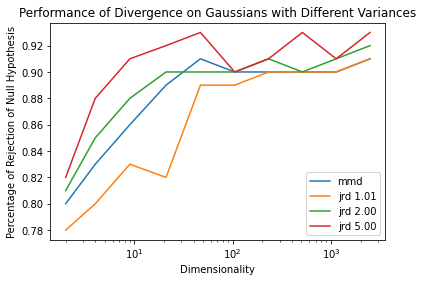

In [7]:
# compute averages
compactResults_mmd = np.mean(varResults_mmd[:,:,:], axis=0)
averaged_mmd = np.mean(compactResults_mmd, axis=1)
plt.plot(dimensionList, averaged_mmd, label='mmd')

for alphaIdx, alpha in enumerate(alphaList):
    compactResults_jrd = np.mean(varResults_jrd[alphaIdx,:,:,:], axis=0)
    averaged_jrd = np.mean(compactResults_jrd, axis=1)
    plt.plot(dimensionList, averaged_jrd, label='jrd %.2f' % alpha)

plt.title("Performance of Divergence on Gaussians with Different Variances")
plt.legend()
plt.xlabel("Dimensionality")
plt.ylabel("Percentage of Rejection of Null Hypothesis")
plt.xscale('log')
plt.show()